In [87]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [89]:
!kaggle datasets download -d samaneheslamifar/facial-emotion-expressions

 97% 117M/121M [00:00<00:00, 155MB/s] 
100% 121M/121M [00:00<00:00, 152MB/s]


In [90]:
!unzip facial-emotion-expressions.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [91]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2
import os

data_dir = '../content/images'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['images', 'validation', 'train']
Train Classes - ['sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear', 'angry']
Validation Classes - ['sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear', 'angry']


In [92]:
# Creating the Pathlib PATH objects
train_path = Path("/kaggle/input/facial-emotion-expressions/images/train")
valid_path = Path("/kaggle/input/facial-emotion-expressions/images/validation")

In [93]:
batch_size = 72
epochs = 45
img_channel = 9
img_width, img_height = (45,45)
train_dataset_main = data_dir + "/train"
valid_dataset_main = data_dir + "/validation"

In [94]:
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is creating ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df


Train dataset is creating ...
Train dataset is created !
Validation dataset is creating ...
Validation dataset is created !
train samples: 28821 
 validation samples: 7066


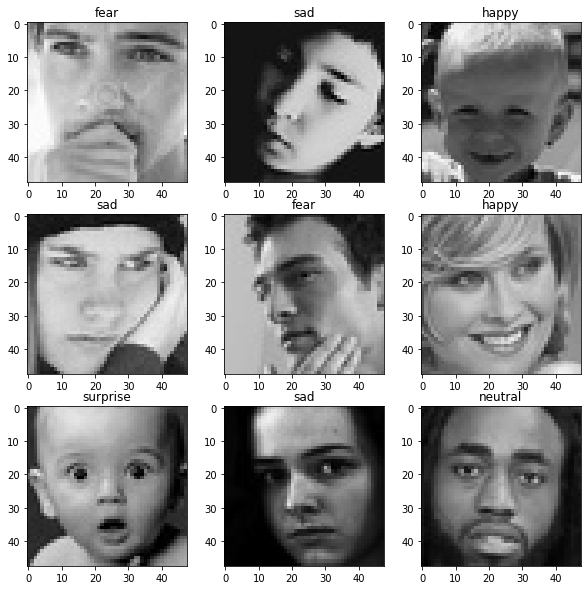

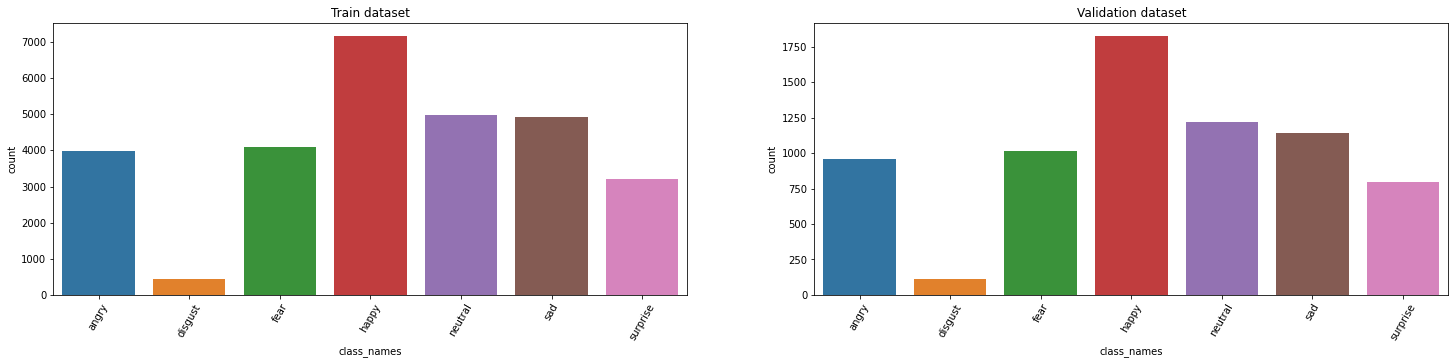

{0: 1.7941397, 1: 16.431192, 2: 1.7460395, 3: 1.0, 4: 1.4379767, 5: 1.4507898, 6: 2.2352574}


(48, 48, 3)

In [95]:
train_df = create_dataset_df(train_dataset_main, "Train dataset")

valid_df=create_dataset_df(valid_dataset_main, "Validation dataset")

print(f"train samples: {len(train_df)} \n validation samples: {len(valid_df)}")
def vizualizing_images(df,n_rows,n_cols):
    plt.figure(figsize=(10,10))
    for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df))
        img = cv2.imread(df.img_path[index])
        class_nm = df.class_names[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(class_nm)
    plt.show()
vizualizing_images(train_df, 3, 3)

plt.figure(figsize=(25,5))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_names"),x="class_names")
plt.title("Train dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_names"),x="class_names")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()

from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_df["class_names"] = Le.fit_transform(train_df["class_names"])

#train_df["class_names"].value_counts()


valid_df["class_names"] = Le.transform(valid_df["class_names"])
#One Hot encoding
train_labels = tf.keras.utils.to_categorical(train_df["class_names"])
valid_labels = tf.keras.utils.to_categorical(valid_df["class_names"])
train_labels[:10]
train_labels.sum(axis=0)

# Compute class weights 

classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)
input_image = cv2.imread(train_df.img_path[0])

input_image.shape


In [96]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
  tf.device(gpus[0])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 12.2 µs


(64, 96, 96, 3)
(64, 7)
sad
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
(64, 96, 96, 3)
(64, 7)
sad
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         1622144   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 3, 3, 128)         0         
                                                                 
 global_average_pooling2d_2   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 

(28821, 7066)

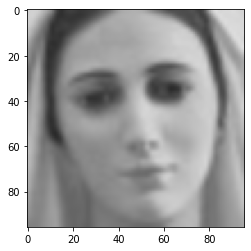

In [97]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 64

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE #to find a good allocation of its CPU budget across all parameters
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

# Creating Train Dataset object and Verifying it
%time 
train_dataset = get_dataset(train_df["img_path"], train_labels)

#iter() returns an iterator of the given object
#next() returns the next number in an iterator
image , label = next(iter(train_dataset)) 
print(image.shape)
print(label.shape)
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


%time 
val_dataset = get_dataset(valid_df["img_path"] , valid_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Dense, Input, GlobalAveragePooling2D


backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

n = 64
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)
#
len(train_labels),len(valid_labels)


In [98]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=12,
    callbacks=[early_stopping],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)
model.layers[0].trainable = False
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2)
model.summary()


# 2nd Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)
# Save Model
#model.save("FacialExpressionModel.h5")
# Save Label Encoder 
##def save_object(obj , name):
  ###pickle_obj.close()
#save_object(Le, "LabelEncoder")

Epoch 1/12
450/450 [==============================] - 162s 240ms/step - loss: 1.0073 - accuracy: 0.8492 - precision: 0.8587 - recall: 0.8389 - val_loss: 8.3434 - val_accuracy: 0.1349 - val_precision: 0.1349 - val_recall: 0.1349
Epoch 2/12
450/450 [==============================] - 105s 233ms/step - loss: 1.1172 - accuracy: 0.8377 - precision: 0.8469 - recall: 0.8276 - val_loss: 12.2643 - val_accuracy: 0.1338 - val_precision: 0.1338 - val_recall: 0.1338
Epoch 3/12
450/450 [==============================] - 106s 236ms/step - loss: 0.9891 - accuracy: 0.8430 - precision: 0.8565 - recall: 0.8282 - val_loss: 8.1701 - val_accuracy: 0.1345 - val_precision: 0.1346 - val_recall: 0.1345
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 conv2d_2 (Conv2D)          

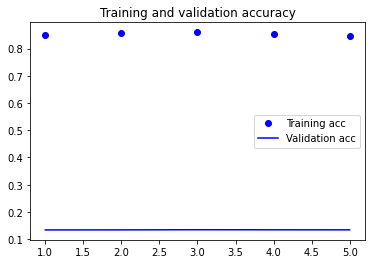

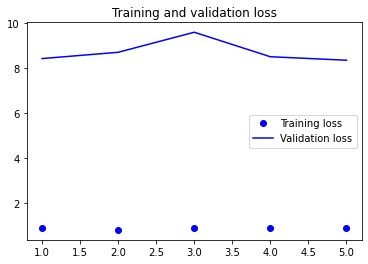

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# history.history